In [1]:
import numpy as np
import pandas as pd
#import xarray as xr
import matplotlib.pyplot as plt
import sys
import os
from utils import SHIPS_preprocess
import json

Load scale factors for SHIPS data.  We need to rescale some of the SHIPS predictors as many of them have been scaled up to make their values ints instead of floats. 

In [2]:
with open('SHIPS_factors.txt') as f:
    SHIPS_factors = f.read()
SHIPS_js = json.loads(SHIPS_factors)
SHIPS_js

{'TIME': [1, 'hr', 'time rel to current case'],
 'VMAX': [1, 'kt', 'max surf wind'],
 'MSLP': [1, 'hPa', 'min slp'],
 'TYPE': [1, 'n/a', 'storm type'],
 'HIST': [1, 'n/a', 'storm hist'],
 'DELV': [1, 'kt', 'intensity change (rel to 0)'],
 'INCV': [1, 'kt', '6 hr intensity change'],
 'LAT': [10, 'deg W', 'storm lat'],
 'LON': [10, 'deg N', 'storm lon'],
 'CSST': [10, 'C', 'clim. SST'],
 'CD20': [1, 'm', 'clim. depth 20C isotherm'],
 'CD26': [1, 'm', 'clim. depth 26C isotherm'],
 'COHC': [1, 'kJ-cm^-2', 'clim. ocean heat content'],
 'DTL': [1, 'km', 'dist. nearest land'],
 'OAGE': [10, 'hr', 'ocean age'],
 'NAGE': [10, 'hr', 'normalized ocean age'],
 'RSST': [10, 'C', 'Reynolds SST'],
 'DSST': [10, 'C', 'daily Reynolds SST'],
 'DSTA': [10, 'C', 'daily av. Renolds SST'],
 'PHCN': [1, 'kJ-cm^-2', 'est. ocean heat content'],
 'U200': [10, 'kt', '200 hPa U, r=200-800km'],
 'U20C': [10, 'kt', '200 hPa U, r=0-500km'],
 'V20C': [10, 'kt', '200 hPa V, r=0-500km'],
 'E000': [10, 'K', '1000 hPa th

We'll processs each basin separately.  So select a basin (`ATLANTIC`, `EAST_PACIFIC`, `WEST_PACIFIC`, or `SOUTHERN_HEM`)

In [3]:
BASIN = 'SOUTHERN_HEM'
#
fname_load = 'DATA/processed/SHIPS_predictors_full_{reg}.csv'.format(reg=BASIN)
SHIPS_load = pd.read_csv(fname_load)
SHIPS_load = SHIPS_load.drop(columns='Unnamed: 0')

Double check to make sure our mask is working

In [5]:
check_IR00 = SHIPS_load['IR00'].loc[18:]
IR00_mask = check_IR00.mask(boop==9999.0)
IR00_mask

18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
          ... 
361348    22.0
361349    30.0
361350    53.0
361351    55.0
361352     NaN
Name: IR00, Length: 361335, dtype: float64

Now, we rescale the SHIPS predictors.  We take the scaling factors from the `json` file we created earlier and divide a given predictor by its scaling factor (assuming it has one; not all predictors have scaling factors). 

In [6]:
col_names = SHIPS_load.columns
for i_col in col_names:
    print('feature is ',i_col)
    if i_col in SHIPS_js.keys():
        print("yay")
        factor = SHIPS_js[i_col][0]
        print('divide by ',factor)
        SHIPS_load[i_col] = SHIPS_load[i_col]/factor
    else:
        print("nay")

feature is  ATCFID
nay
feature is  CASE
nay
feature is  NAME
nay
feature is  DATE_full
nay
feature is  TIME
yay
divide by  1
feature is  VMAX
yay
divide by  1
feature is  MSLP
yay
divide by  1
feature is  TYPE
yay
divide by  1
feature is  HIST
yay
divide by  1
feature is  DELV
yay
divide by  1
feature is  INCV
yay
divide by  1
feature is  LAT
yay
divide by  10
feature is  LON
yay
divide by  10
feature is  CSST
yay
divide by  10
feature is  CD20
yay
divide by  1
feature is  CD26
yay
divide by  1
feature is  COHC
yay
divide by  1
feature is  DTL
yay
divide by  1
feature is  OAGE
yay
divide by  10
feature is  NAGE
yay
divide by  10
feature is  RSST
yay
divide by  10
feature is  RSST_AGE
nay
feature is  PHCN
yay
divide by  1
feature is  U200
yay
divide by  10
feature is  U20C
yay
divide by  10
feature is  V20C
yay
divide by  10
feature is  E000
yay
divide by  10
feature is  EPOS
yay
divide by  10
feature is  ENEG
yay
divide by  10
feature is  EPSS
yay
divide by  10
feature is  ENSS
yay
div

We have a few options for dealing with land:
1.  <code>SIMPLE_MASK</code>: Mask out all cases where <code>DTL</code> at <code>TIME = 0</code> or <code>TIME = max_time</code> is less than some <code>DTL_thresh</code> (normally, <code>DTL_thresh = 100 km</code>)
2.  <code>SIMPLE_w_INT</code>: Apply mask if <code>DTL</code> for a given case is less than <code>DTL_thresh</code> at any point between <code>TIME = 0</code> and <code>TIME = max_time</code>. 
3.  <code>SCALAR_MASK</code>: For all cases where <code>DTL</code> at <code>TIME = 0</code> or <code>TIME = max_time</code> is less than some <code>DTL_thresh</code>, multiply the <code>DTL</code> by a scaling factor of 0.1 and use this <code>DTL_scalar</code> to reduce all SHIPS predictors accordingly. If <code>DTL</code> <= 0, scaling factor is 0. 
4.  <code>SCALAR_MASK_w_INT</code>: As in 3, but apply if <code>DTL <= DTL_thresh</code> at any point between <code>TIME = 0</code> and <code>TIME = max_time</code>. 
5.  <code>no_mask</code>: do not mask out over land.
    
<i>Note to self</i>:  Types 1, 2, and 5 have been implemented; 3 and 4 are future work

Apply desired mask (note: this step can take a few minutes)

In [7]:
mask_TYPE = 'SIMPLE_MASK'
to_IND = ['ATCFID','CASE','NAME','DATE_full','TIME']
SHIPS_mask = SHIPS_preprocess.apply_land_mask(SHIPS_load,mask_TYPE,to_IND)
# SHIPS_mask.set_index(['ATCFID','TIME']).xs(('AL012020',0))

applying mask


Select specific years and forecast hours to include.  Default settings are:
* <b>years</b>: 2005-most recent year with full SHIPS data (usually `current_year - 1`, unless it's very early in the year and the best-tracks haven't been made available).  
* <b>hours</b>: -12 hours to 24 hours (could go out to 48 or 72 if desired)

In [8]:
YR_first = 2005
YR_last = 2022
HR_first = -12
HR_last = 24
#
YEARS_use = np.arange(YR_first,YR_last,1)
FORE_use = np.arange(HR_first,HR_last+1,6)

Trim to desired years.  Hold off on trimming hours for now; the way the IR predictors are arranged means we need forecast hours past 24. 

In [9]:
SHIPS_mask = SHIPS_mask.reset_index()
SHIPS_trim_yrs = SHIPS_mask[pd.to_datetime(SHIPS_mask['DATE_full']).dt.year.isin(YEARS_use)]

Identify key predictors we want to use.  We'll differentiate between dynamical predictors and IR predictors because we process them a little differently.  Note that <code>CASE</code>, <code>NAME</code>, <code>DATE_full</code>, and <code>TIME</code> are included in both datasets for identification purposes.

For now, we use the following dynamical predictors:
* <code>SHRG</code>: generalized midlevel shear [kt$*$10]
* <code>D200</code>: upper level divergence [s$^{-1} \cdot 10^7$]
* <code>Z850</code>: lower level vorticity [s$^{-1} \cdot 10^7$]
* <code>VMAX</code>: maximum wind speed [kt] (use <code>VMAX</code> at time = 0)
* <code>VMPI</code>: maximum potential intensity [kt] (calculated based on <code>VMAX$_{t=0}$</code>
* <code>DELV</code>: change in intensity over previous 12 hours [kt] (use <code>DELV</code> from time = -12-0)
* <code>RHMD</code>: mid-level relative humidity [%]
* <code>NSST / RSST </code> (depends on <code>BASIN</code>): sea surface temperature [C*10]
* <code>NOHC / RHCN </code> (depends on <code>BASIN</code>): ocean heat content [J/kg-C if NOHC, kJ/cm$^2$ if RHCN]

If desired, we calculate an additional predictor, <code>POT</code> (potential intensity), by subtracting actual maximum winds from maximum potential intensity,
$$ POT_{time=i} = VMPI_{time=i} - VMAX_{time=0}$$

Otherwise, we'll use $VMPI$ and $VMAX_{time=0}$ as separate predictors, along with SST.

In [10]:
if (BASIN == 'ATLANTIC') | (BASIN=='EAST_PACIFIC') | (BASIN == 'CENTRAL_PACIFIC'):
    SST_sel = 'NSST'
    OHC_sel = 'NOHC'
else:
    SST_sel = 'RSST'
    OHC_sel = 'RHCN'
PREDICTORS_sel = ['ATCFID','CASE','NAME','DATE_full','DTL','TIME','TYPE','SHRG','D200','Z850','VMAX','VMPI','DELV','RHMD',SST_sel,OHC_sel]
predictand_name = 'VMAX'
is_INTERP = True
calc_POT = True

So now we select desired dynamical predictors.  We will keep only storm type 1 (for tropical cyclones), mask missing values (demarcated by 9999s), and calculate <code>POT</code>.  Finally, if we select <code>is_interp = True</code>, we'll linearly interpolate over missing values for our dynamic predictors. 

In [11]:
SHIPS_dyn_out = SHIPS_preprocess.create_SHIPS_predictors_dyn(SHIPS_trim_yrs,
                            PREDICTORS_sel,predictand_name,is_INTERP,FORE_use,calc_POT)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


interpolating over missing values


Multiply Z850 by -1 if we are in the SH

In [12]:
if BASIN == 'SOUTHERN_HEM':
    print('multiply by -1 for SH')
    print('before multiplying, Z850 mean is ',SHIPS_dyn_out['Z850'].mean())
    SHIPS_dyn_out['Z850'] = -1*SHIPS_dyn_out['Z850']
    print('after multiplying, Z850 mean is ',SHIPS_dyn_out['Z850'].mean())
    # SHIPS_dyn_out['D200'] = -1*SHIPS_dyn_out['D200']

multiply by -1 for SH
before multiplying, Z850 mean is  9.257925256003923e-05
after multiplying, Z850 mean is  -9.257925256003923e-05


The IR predictors are derived from GOES data and are not actually time-dependent. They are calculated based on GOES data close to the time of each case.  <code>IR00</code> predictors are generally related to GOES Ch4 brightness temperatures averaged over some radial area (relative to the storm center).  <code>IRM1</code> and <code>IRM3</code> are the same as <code>IR00</code> but derived from satellite data taken 1.5 and 3 hours earlier, respectively, than <code>IR00</code>. If <code>IR00</code> is missing, we can fill it in with <code>IRM1</code>.  If <code>IRM1</code> is missing, we can use <code>IRM3</code>.  If all three are missing for a given case, we will use <code>NaN</code> values. 

The <code>PC00</code> predictors are principal components and related variables from IR imagery. Again, <code>PC00</code> is derived from satellite imagery and is not time-dependent. Regarding <code>PCM1</code> and <code>PCM3</code>, we will follow the same procedure as the <code>IRM1</code> and <code>IRM3</code>.  

Ultimately, we're only going to use a few IR predictors.  Since they are not time-dependent, we'll populate the <code>time</code> dimension with the same values of <code>IR00</code>, for example.  The variables we are interested in for our actual predictions are:
* <code>IR00</code> (and <code>IRM1/IRM3</code> as needed):
    * Average GOES Ch4* brightness temperature from r=0-200 km [deg C * 10], stored at t = +6 hours
    * Standard deviation of GOES Ch4 brightness temperature from r=0-200 km [deg C * 10], stored at t = +12 hours
    * Percent area of GOES Ch4 brightness temperature < -50 C for r = 50-200 km [%], stored at t = +54 hours
    * Storm size paramter, stored at t = +108 hours
* <code>PC00</code> (and <code>PCM1/PCM3</code> as needed):
    * First four principal components of IR imagery, stored at 0, +6, +12, and +18 hours, respectively
    

*note to self, Ch4 refers to Channel 4 in the old GOES.  What this actually refers to is the 10.3 um band, which is channel 13 on the current versions of GOES

In [13]:
predictors_sel_IR = ['ATCFID','CASE','NAME','DATE_full','TIME','TYPE','IR00','IRM1','IRM3','PC00','PCM1','PCM3']
# Identify time indices for desired IR variables (recall they are NOT time series)
IR00_time_ind = [6,12,54,108]
IR00_var_names = ['GOES Tb','s(GOES Tb)','pct < -50C','storm size']
PC00_time_ind = [0,6,12,18]
PC00_var_names = ['PC1','PC2','PC3','PC4']

In [14]:
import warnings
warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)

SHIPS_IR_out = create_SHIPS_predictors_IR(SHIPS_trim_yrs,
                        predictors_sel_IR,FORE_use,IR00_time_ind,IR00_var_names,PC00_time_ind,PC00_var_names)

In [15]:
SHIPS_IR_out = SHIPS_preprocess.create_SHIPS_predictors_IR(SHIPS_trim_yrs,
                        predictors_sel_IR,FORE_use,IR00_time_ind,IR00_var_names,PC00_time_ind,PC00_var_names)

Combine into one dataframe

In [16]:
SHIPS_process_all = SHIPS_dyn_out
SHIPS_process_all[IR00_var_names] = SHIPS_IR_out[IR00_var_names]
SHIPS_process_all[PC00_var_names] = SHIPS_IR_out[PC00_var_names]

In [17]:
SHIPS_process_all['CYCLONE NO'] = SHIPS_process_all.ATCFID.str[2:4]

Get <code>n</code> hour change in <code>VMAX</code> (intensity change). Specify start of period, end of period, and length of period, in hours. We'll calculate the SHIPS model forecast <code>n</code>-hour change in <code>VMAX</code>, and the actual <code>VMAX</code> 24 hours later. SHIPS predictors are released in 6-hour intervals, so <code>n_hours</code> should be in 6-hourly increments.  

In [18]:
diff = SHIPS_preprocess.calc_d24_VMAX(SHIPS_process_all,0)


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


Sanity check to make sure our 24-hour change in VMAX is centered around 0

In [19]:
diff = diff.rename(columns={'VMAX':'d24_VMAX'})

<AxesSubplot:xlabel='d24_VMAX', ylabel='Density'>

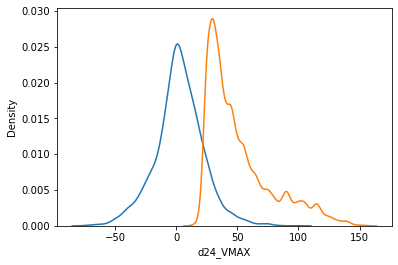

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(data=diff.reset_index(),x='d24_VMAX')
sns.kdeplot(data=SHIPS_process_all.reset_index(),x='VMAX')

Save

In [21]:
if is_INTERP:
    interp_str = 'INTERP'
else:
    interp_str = 'NO_INTERP'
#if is_ocean_only:
#    ocean_str = 'OCEAN_ONLY'
#else:
#    ocean_str = 'OCEAN_LAND'
fname_save = 'DATA/processed/SHIPS_processed_{BASIN}_set_yrs_{YR_first}-{YR_last}_'\
'max_fore_hr_{HR_last}_{interp}_land_mask_{mask_type}.csv'.format(BASIN=BASIN,YR_first=YR_first,YR_last=YR_last-1,
                                                    HR_last=HR_last,interp=interp_str,mask_type=mask_TYPE)
SHIPS_process_all.to_csv(fname_save)

In [22]:
print('saved ',fname_save)

saved  DATA/processed/SHIPS_processed_SOUTHERN_HEM_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
